<a href="https://colab.research.google.com/github/ACROS-UMBC/UMBC-PHYS640-440/blob/Fall2021/Air_temperature_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# An exercise to analyze the global air temperature data from NOAA using Numpy and plot results using Matplotlib

First load the numpy libraries 

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import importlib
netcdf = importlib.util.find_spec("netCDF4")
if netcdf is not None:
  import netCDF4
else:
  !pip install netCDF4

first load the air temperature data

In [33]:
def read_air_temp():
  # first let's check the air temperature dats has been downloaded yet?
  import os
  file_downloaded = os.path.isfile('surface_air_temp.nc')
  # if not, let's download it from NCEP website
  if ~file_downloaded:
    import urllib.request as urldownload
    air_temp_file_url='ftp://ftp2.psl.noaa.gov/Datasets/ncep.reanalysis.derived/surface/air.sig995.mon.mean.nc'
    urldownload.urlretrieve(air_temp_file_url, 'surface_air_temp.nc')
  # after download, read in the data
  nc_fid = netCDF4.Dataset('surface_air_temp.nc', 'r')
  lats = nc_fid.variables['lat'][:]  # Latitude points
  lons = nc_fid.variables['lon'][:]  # Longitude points
  time = nc_fid.variables['time'][:] #  Time steps, month after 1948/01
  air = nc_fid.variables['air'][:]    # shape is time, lat, lon as shown above
  nc_fid.close()
  return (lats, lons, time, air)

In [34]:
lats, lons, time, air = read_air_temp()

Let's figure out the dimension and size of the data

In [36]:
print(air.shape)


(883, 73, 144)


latitude grids: 73 points <br>
longitude grids: 144 points <br>
time steps: 883 months <br>
global air temperature: 883 x 73 x 144

## simple analysis

first let's do some simple analysis. Let's try to compute the following <br>
1) global mean tempature averaged over all lat, lon and time grids <br>
2) time series of global mean temperature averaged over lat & lon grids <br>
3) averaged zonal mean temperature (averaged over time and lons) <br>

In [37]:
# get the simple global mean temperature
print('simple global mean temperature',air.mean(),'degree C')

simple global mean temperature 4.446976 degree C


In [38]:
# time series of global mean temperature averaged over lat & lon grids
T_global_avg_time = air.mean(axis=(1,2))
print(T_global_avg_time.shape)

(883,)


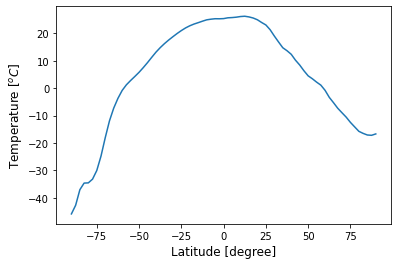

In [39]:
# averaged zonal mean temperature (averaged over time and lons)
T_zonal = air.mean(axis=(0,2))
fig,ax=plt.subplots()
ax.plot(lats,T_zonal )
ax.set_xlabel('Latitude [degree]',fontsize='large')
ax.set_ylabel(r'Temperature [$^o C$]',fontsize='large')
plt.show()

## conditional sampaling

1) select the tropical region with lats>-30 & lats<30 and derive the averaged temperature of the tropical region <br>
2) select the arctic region with lats > 60 and derive the averaged temperature of the tropical region <br>
3) select the continental U.S. region and derive the averaged temperature of CONUS [20N~50N 130W ~ 70W or 230 ~ 290 ]

In [40]:
#select the tropical region with lats>-30 & lats<30 and derive the averaged temperature of the tropical region 
tropics_mask = (lats>-30) & (lats<30) 
print(lats[tropics_mask])
print(lats[tropics_mask].shape)
air_tropics=air[:,tropics_mask,:]
print(air_tropics.shape)
print('mean temp. of tropical region',air_tropics.mean())

[ 27.5  25.   22.5  20.   17.5  15.   12.5  10.    7.5   5.    2.5   0.
  -2.5  -5.   -7.5 -10.  -12.5 -15.  -17.5 -20.  -22.5 -25.  -27.5]
(23,)
(883, 23, 144)
mean temp. of tropical region 24.299587


In [41]:
#3) select the continental U.S. region and derive the averaged temperature of CONUS [20N~50N 130W ~ 70W or 230 ~ 290 ]
conus_lats = (lats<50) & (lats > 20)
conus_lons = (lons<290) & (lons > 230)
print(lats[conus_lats])
print(lons[conus_lons])
air_conus = air[:,conus_lats,:][:,:,conus_lons]
print(air_conus.shape)

[47.5 45.  42.5 40.  37.5 35.  32.5 30.  27.5 25.  22.5]
[232.5 235.  237.5 240.  242.5 245.  247.5 250.  252.5 255.  257.5 260.
 262.5 265.  267.5 270.  272.5 275.  277.5 280.  282.5 285.  287.5]
(883, 11, 23)


## reshape the data
Currently, the air temperature data have 883 months, i.e., 73 years (since 1948) + 7 month. 

1) for convinience, let's get rid of the last 7 months <br>
2) then convert the shape of the air temperature data to 73 X 12 X 73 X 144 <br> 
3) then derive the average air temperature of CONUS during the summer (JJA) and winter (DJF) months

In [47]:
nmon,nlat,nlon = air.shape
print(nmon,nlat,nlon)
nyear = nmon//12
residual = nmon%12
print(nyear)
air_reshape = air[0:-residual,:,:].reshape(nyear,12,nlat,nlon)
print(air_reshape.shape)

883 73 144
73
(73, 12, 73, 144)


In [49]:
air_conus_summer = air_reshape[:,[5,6,7],:,:][:,:,conus_lats,:][:,:,:,conus_lons]
air_conus_winter = air_reshape[:,[-1,0,1],:,:][:,:,conus_lats,:][:,:,:,conus_lons]
print(air_conus_summer.mean(),air_conus_winter.mean())


22.157602 6.9290385


## data analysis: line plot 
On the basis of the results plots the following analysis <br>
1) time series of global mean, tropical mean and arctic mean, temperatures <br>
2) plot the seasonal cycle of northern hemispheric midlatitude temperature 

(-90.0, 90.0)

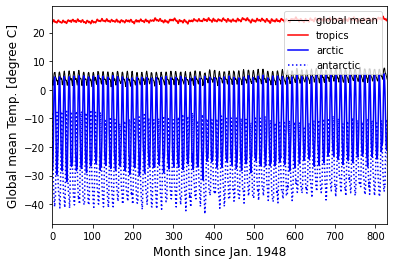

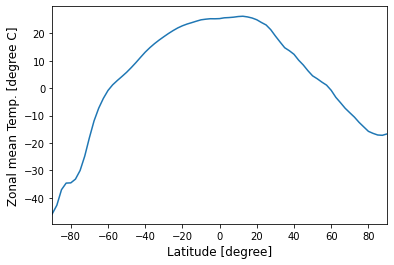

In [50]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()

ax.plot(air.mean(axis=(1,2)),color='k',label='global mean',lw=1)
ax.plot(air[:,tropics_mask,:].mean(axis=(1,2)),color='r',label='tropics')
ax.plot(air[:,lats>60,:].mean(axis=(1,2)),color='b',label='arctic')
ax.plot(air[:,lats<-60,:].mean(axis=(1,2)),color='b',linestyle='dotted',label='antarctic')

ax.set_xlabel('Month since Jan. 1948',fontsize='large')
ax.set_ylabel('Global mean Temp. [degree C]',fontsize='large')
ax.set_xlim([0,829])
ax.legend(loc='upper right')

# plot the zonal mean temperature 
fig,ax = plt.subplots()
T_zonal = air.mean(axis=(0,2))
ax.plot(lats, T_zonal)
ax.set_xlabel('Latitude [degree]',fontsize='large')
ax.set_ylabel('Zonal mean Temp. [degree C]',fontsize='large')
ax.set_xlim([-90,90])



shape of the data (73, 12, 73, 144)
shape of the T_Np_season (73, 12, 12, 144)
shape of the T_Np_season_mean (12,)
shape of the T_Sp_season (73, 12, 12, 144)
shape of the T_Sp_season_mean (12,)


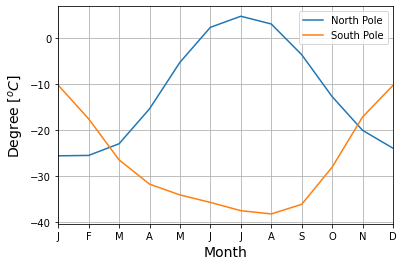

In [51]:
Np = lats>60.0
Sp = lats<-60.0
# print(Np)
# print(lats)
# print(lats[0:12])
print('shape of the data',air_reshape.shape)
T_Np_season = air_reshape[:,:,Np,:]
print('shape of the T_Np_season',T_Np_season.shape)
T_Np_season_mean = np.mean(T_Np_season,axis=(0,2,3))
print('shape of the T_Np_season_mean',T_Np_season_mean.shape)


T_Sp_season = air_reshape[:,:,Sp,:]
print('shape of the T_Sp_season',T_Sp_season.shape)
T_Sp_season_mean = np.mean(T_Sp_season,axis=(0,2,3))
print('shape of the T_Sp_season_mean',T_Sp_season_mean.shape)
#T_Sp_season = air_reshape

fig, ax = plt.subplots()
months = np.arange(1,13)
ax.plot(months,T_Np_season_mean,label='North Pole')
ax.plot(months,T_Sp_season_mean,label='South Pole')
ax.set_xlim([1,12])
ax.set_xlabel('Month',fontsize=14)
ax.set_ylabel(r'Degree [$^oC$]',fontsize=14)
ax.grid(True)
ax.set_xticks(months)
month_label = ['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A','S','O','N','D']
ax.set_xticklabels(month_label)
ax.legend()
plt.savefig('Seasonal_Temp_of_Poles.png',dpi=300)
plt.show()

## data analysis: color contour
On the basis of the above results plots the following analysis <br>
1) color contour of the global mean temperature <br>
2) color contour of the global mean temperature averaged over year 2000~2010 minus 1950~1960 <br>

x [-10.  -6.  -2.   2.   6.  10.]
y [100. 125. 150. 175. 200.]
shape of x,y,z (6,) (5,) (4, 5)


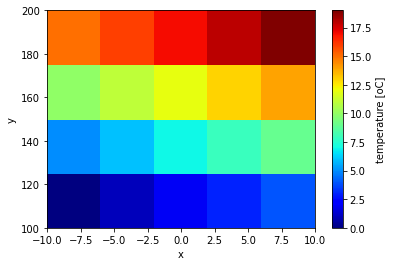

In [52]:
# simple example for pcolormesh: pixel-wise color plot
z=np.arange(20).reshape(4,5)
#print(x)

x = np.linspace(-10,10,6)
y = np.linspace(100,200,5)
print('x',x)
print('y',y)
print('shape of x,y,z',x.shape,y.shape,z.shape)
fig,ax=plt.subplots()
ct=ax.pcolormesh(x,y,z,cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(ct,label='temperature [oC]')
plt.show()




(4, 5) (4, 5)
[[-10.  -6.  -2.   2.   6.]
 [-10.  -6.  -2.   2.   6.]
 [-10.  -6.  -2.   2.   6.]
 [-10.  -6.  -2.   2.   6.]]
[[100. 100. 100. 100. 100.]
 [125. 125. 125. 125. 125.]
 [150. 150. 150. 150. 150.]
 [175. 175. 175. 175. 175.]]


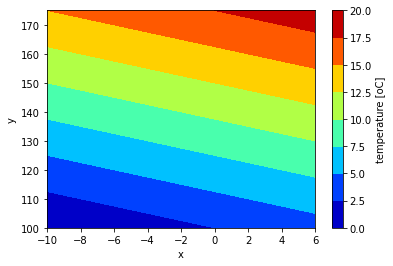

In [53]:
# simple example for contourf: filled color contour
fig,ax=plt.subplots()
xx,yy = np.meshgrid(x[0:-1],y[0:-1])
print(xx.shape,yy.shape)
print(xx)
print(yy)
ct=ax.contourf(xx,yy,z,cmap='jet')
ax.set_xlabel('x')
ax.set_ylabel('y')
plt.colorbar(ct,label='temperature [oC]')
plt.show()
ax.contourf?

(73, 12, 73, 144) (73, 144)


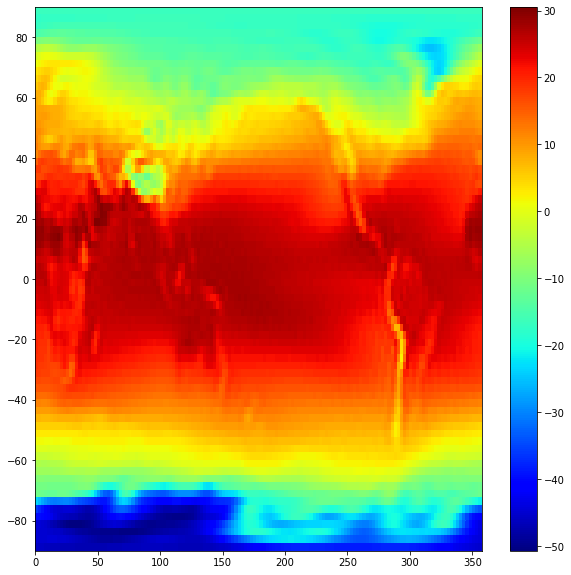

[ 90.   87.5  85.   82.5  80.   77.5  75.   72.5  70.   67.5  65.   62.5
  60.   57.5  55.   52.5  50.   47.5  45.   42.5  40.   37.5  35.   32.5
  30.   27.5  25.   22.5  20.   17.5  15.   12.5  10.    7.5   5.    2.5
   0.   -2.5  -5.   -7.5 -10.  -12.5 -15.  -17.5 -20.  -22.5 -25.  -27.5
 -30.  -32.5 -35.  -37.5 -40.  -42.5 -45.  -47.5 -50.  -52.5 -55.  -57.5
 -60.  -62.5 -65.  -67.5 -70.  -72.5 -75.  -77.5 -80.  -82.5 -85.  -87.5
 -90. ]


In [54]:
# pcolormesh of global mean temperature
T_mean = air_reshape.mean(axis=(0,1))
print(air_reshape.shape,T_mean.shape)
fig,ax=plt.subplots(figsize=[10,10])
pc = ax.pcolormesh(lons,lats,T_mean,cmap='jet')
plt.colorbar(pc)
plt.show()
print(lats)

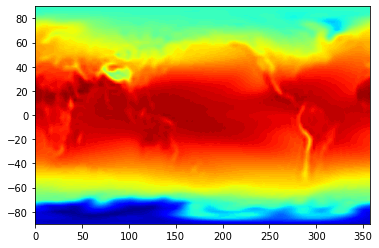

In [55]:
fig,ax = plt.subplots()
xx,yy = np.meshgrid(lons,lats)
ax.contourf(xx,yy,T_mean,levels=100,cmap='jet')
plt.show()
#ax.contourf?


(10, 12, 73, 144)
(73, 144)


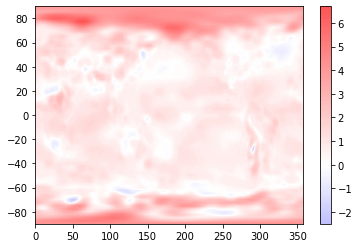

In [56]:
# the difference between the last ten years of T_mean and the first ten years
T_diff=air_reshape[-10:,:,:,:] - air_reshape[0:10,:,:,:]
print(T_diff.shape)
T_diff_mean = T_diff.mean(axis=(0,1))
print(T_diff_mean.shape)

fig,ax = plt.subplots()
xx,yy = np.meshgrid(lons,lats)
cf = ax.contourf(xx,yy,T_diff_mean,levels=100,cmap='bwr',\
                vmin=-10,vmax=10.0)
plt.colorbar(cf)
plt.show()